# Azted G-dDT Test Run

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import os
import plotly.express as px
import seaborn as sns 
import matplotlib.pyplot as plt

import plotly.io as pio
pio.renderers.default = "png"
import math

In [2]:
N_sw = 4_000
N_s = 1
N_t = 250
state_measurements = N_sw * N_s * N_t
measurements_per_second = 8_000
estimated_time_run = state_measurements / measurements_per_second
print(f"Expected run time: {estimated_time_run :.2f}s")

Expected run time: 125.00s


In [3]:
from aztec_gddt.experiment import *

sim_df = psuu_exploratory_run(N_sw, N_s, N_t)

147456
Performing PSuU run

                  ___________    ____
  ________ __ ___/ / ____/   |  / __ \
 / ___/ __` / __  / /   / /| | / / / /
/ /__/ /_/ / /_/ / /___/ ___ |/ /_/ /
\___/\__,_/\__,_/\____/_/  |_/_____/
by cadCAD

cadCAD Version: 0.5.1
Execution Mode: single_proc
Simulation Dimensions:
Entire Simulation: (Models, Unique Timesteps, Params, Total Runs, Sub-States) = (1, 250, 36, 4000, 13)
     Simulation 0: (Timesteps, Params, Runs, Sub-States) = (250, 36, 4000, 13)


Initializing configurations:   0%|          | 0/4000 [00:00<?, ?it/s]

Execution Method: single_proc_exec
Execution Mode: single_threaded


Flattening results:   0%|          | 0/1032000 [00:00<?, ?it/s]

Total execution time: 119.51s


In [4]:
sim_df.columns

Index(['time_l1', 'delta_l1_blocks', 'advance_l1_blocks', 'agents',
       'current_process', 'transactions', 'gas_fee_l1', 'gas_fee_blob',
       'finalized_blocks_count', 'cumm_block_rewards', 'cumm_fee_cashback',
       'cumm_burn', 'token_supply', 'simulation', 'subset', 'run', 'timestep',
       'delta_blocks', 'timestep_in_blocks', 'uncle_count', 'reward_per_block',
       'fee_subsidy_fraction', 'phase_duration_proposal_min_blocks',
       'phase_duration_proposal_max_blocks',
       'phase_duration_reveal_min_blocks', 'phase_duration_reveal_max_blocks',
       'phase_duration_commit_bond_min_blocks',
       'phase_duration_commit_bond_max_blocks',
       'phase_duration_rollup_min_blocks', 'phase_duration_rollup_max_blocks',
       'phase_duration_race_min_blocks', 'phase_duration_race_max_blocks',
       'stake_activation_period', 'unstake_cooldown_period',
       'proposal_probability_per_user_per_block',
       'block_content_reveal_probability', 'tx_proof_reveal_probability

In [26]:
def trajectory_race_mode_fraction(trajectory_df) -> float:
    return trajectory_df.current_process.map(lambda x: (x.phase == SelectionPhase.proof_race) if type(x) == Process else False).mean()


def trajectory_skipped_fraction(trajectory_df) -> float:
    return trajectory_df.current_process.map(lambda x: (x.phase == SelectionPhase.skipped) if type(x) == Process else False).mean()

In [27]:
governance_surface_params = [
    'phase_duration_proposal_min_blocks',
    'phase_duration_proposal_max_blocks',
    'phase_duration_reveal_min_blocks',
    'phase_duration_reveal_max_blocks',
    'phase_duration_commit_bond_min_blocks',
    'phase_duration_commit_bond_max_blocks',
    'phase_duration_rollup_min_blocks',
    'phase_duration_rollup_max_blocks',
    'phase_duration_race_min_blocks',
    'phase_duration_race_max_blocks',
    'reward_per_block'
]

trajectory_id_columns = ['simulation', 'subset', 'run']

agg_columns = ['simulation', 'subset', 'run'] + governance_surface_params

In [48]:
KPIs_per_trajectory = {
    'fraction_race_mode': trajectory_race_mode_fraction,
    'fraction_skipped': trajectory_skipped_fraction
}

kpi_dfs = []
for kpi, kpi_f in KPIs_per_trajectory.items():
    kpi_s = sim_df.head(1000).groupby(agg_columns).apply(kpi_f, include_groups=False)
    kpi_s.name = kpi
    kpi_dfs.append(kpi_s)


all_kpi_df = pd.concat(kpi_dfs, axis=1)

array([[<Axes: title={'center': 'fraction_race_mode'}>,
        <Axes: title={'center': 'fraction_skipped'}>]], dtype=object)

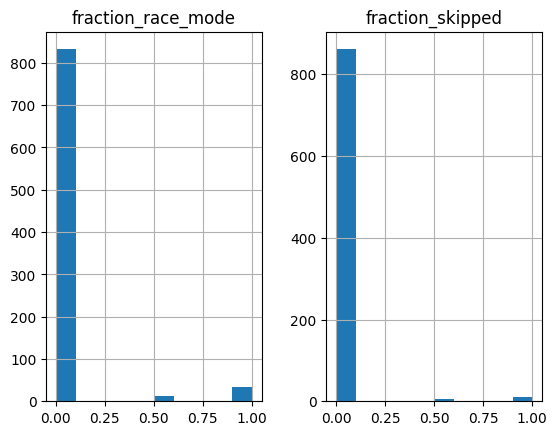

In [49]:
all_kpi_df.hist()

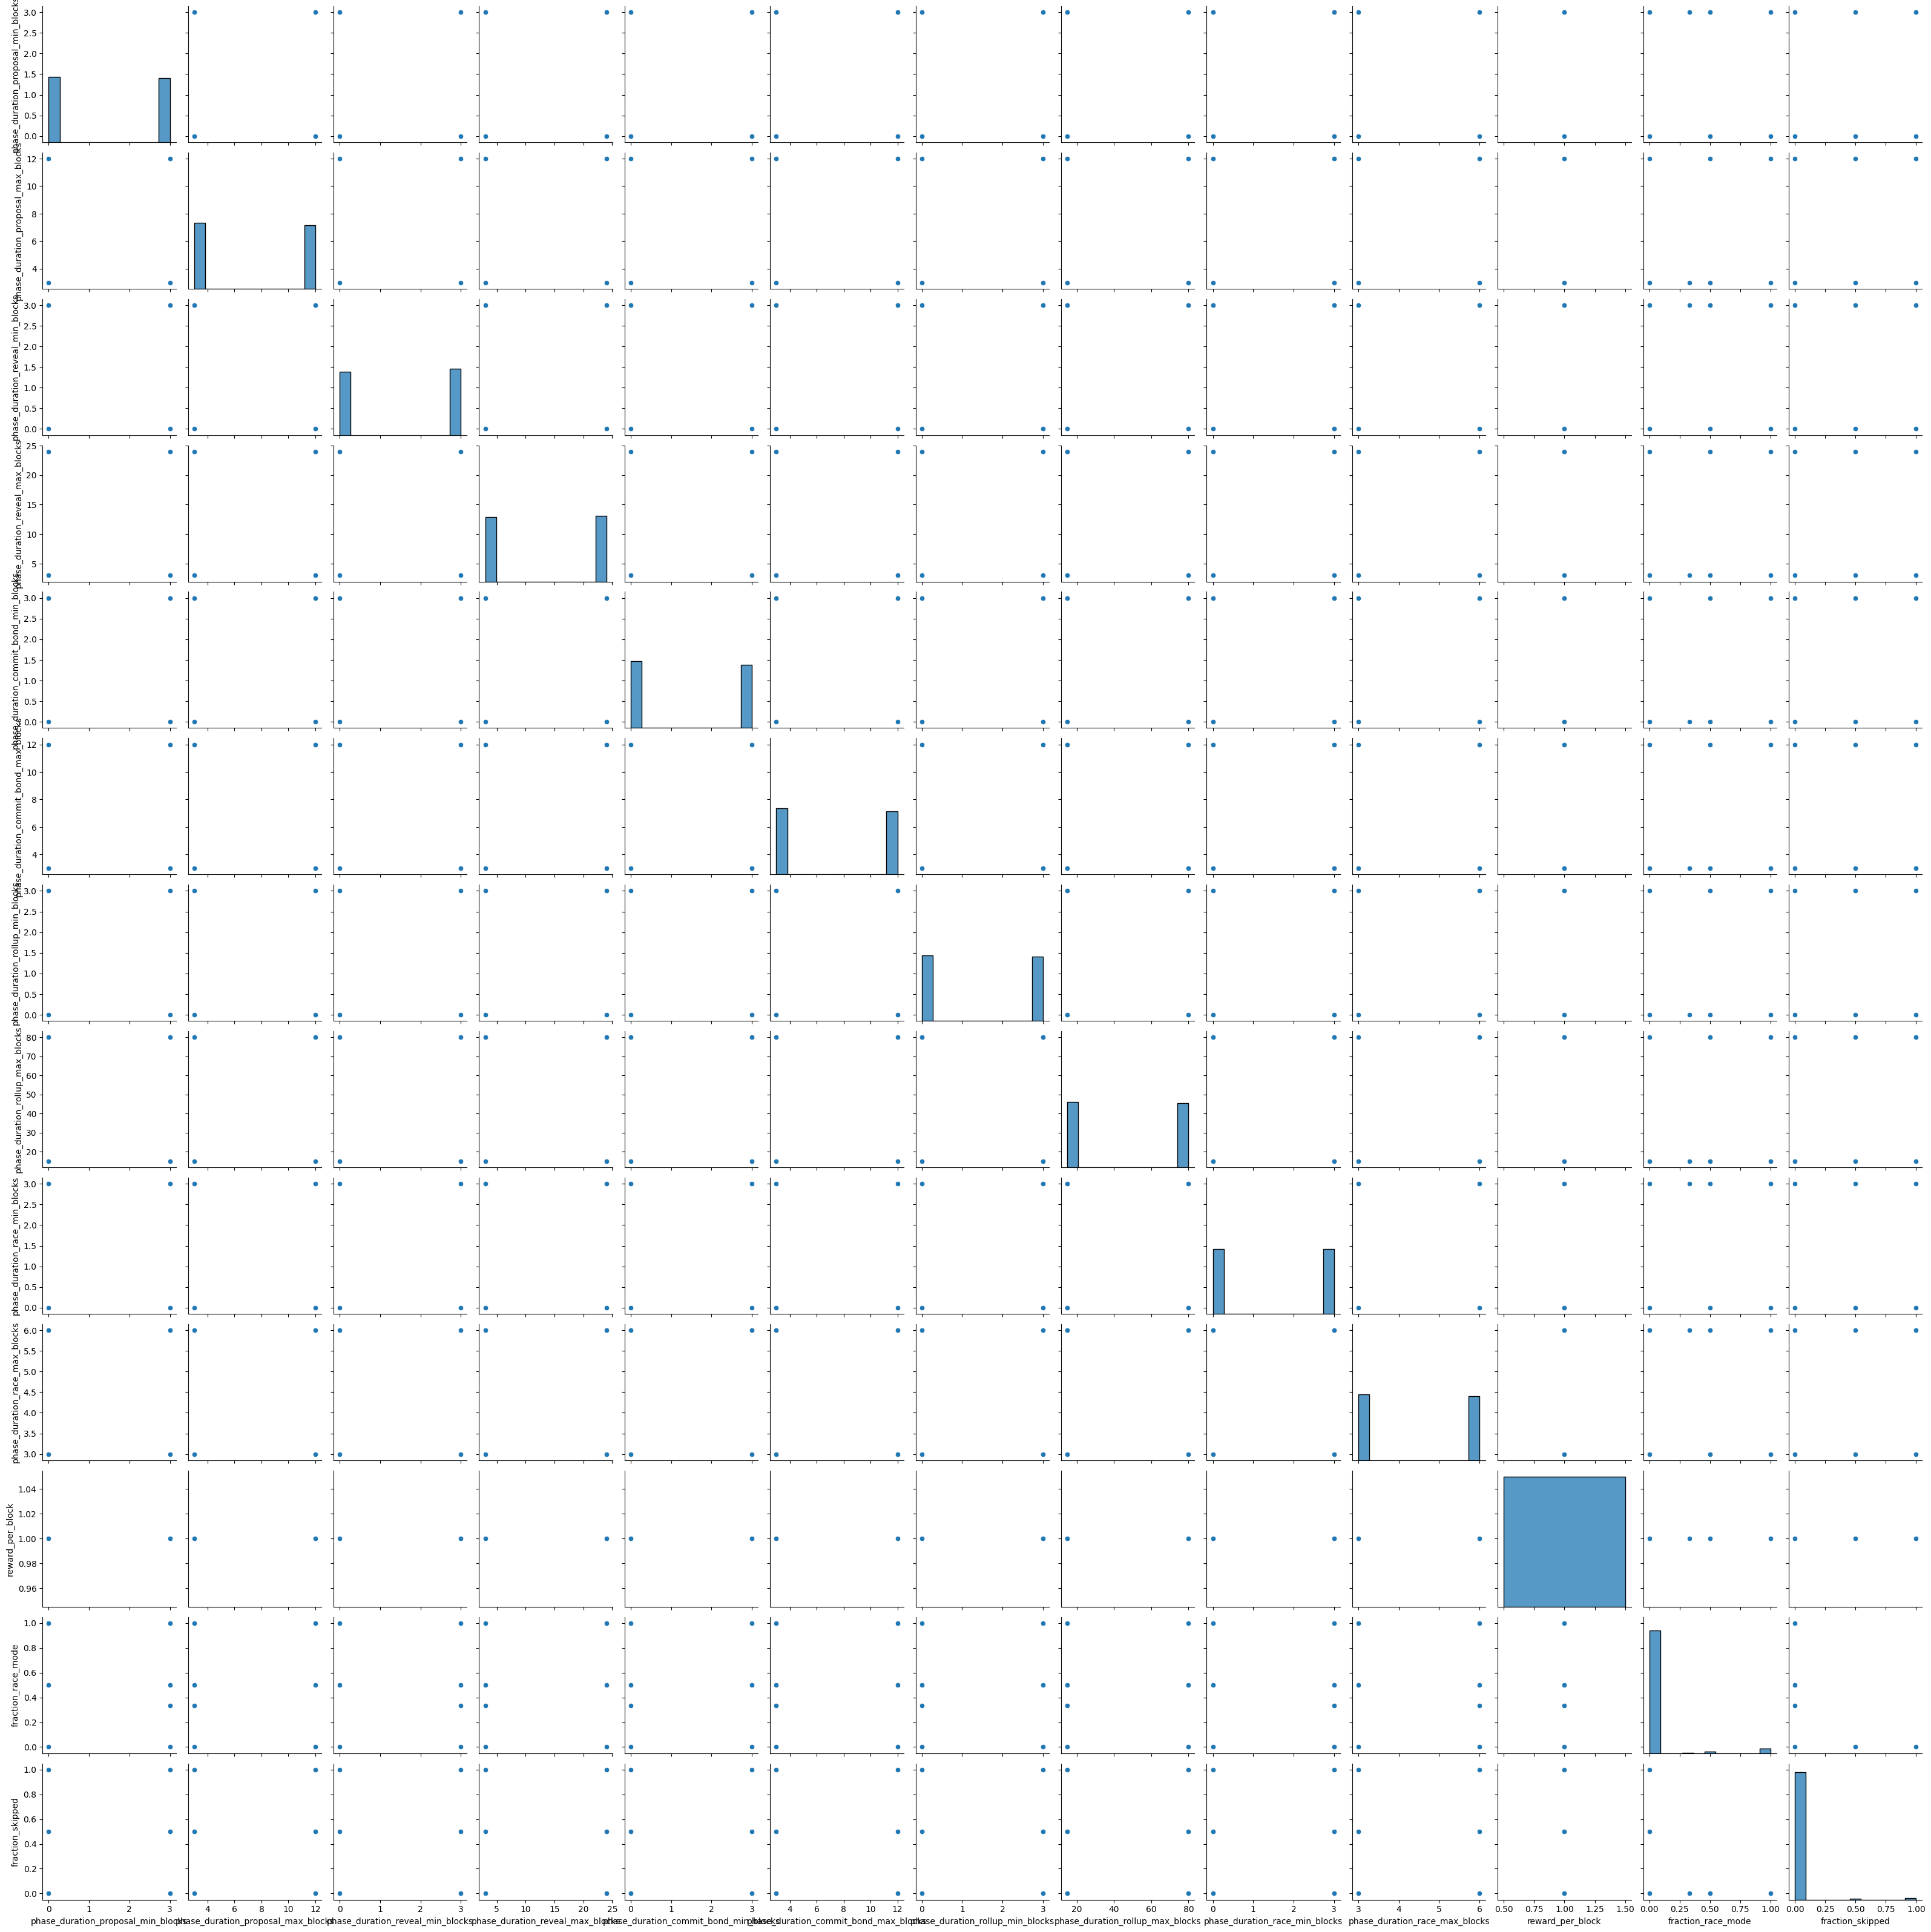

In [53]:
sns.pairplot(all_kpi_df.reset_index().drop(columns=trajectory_id_columns))

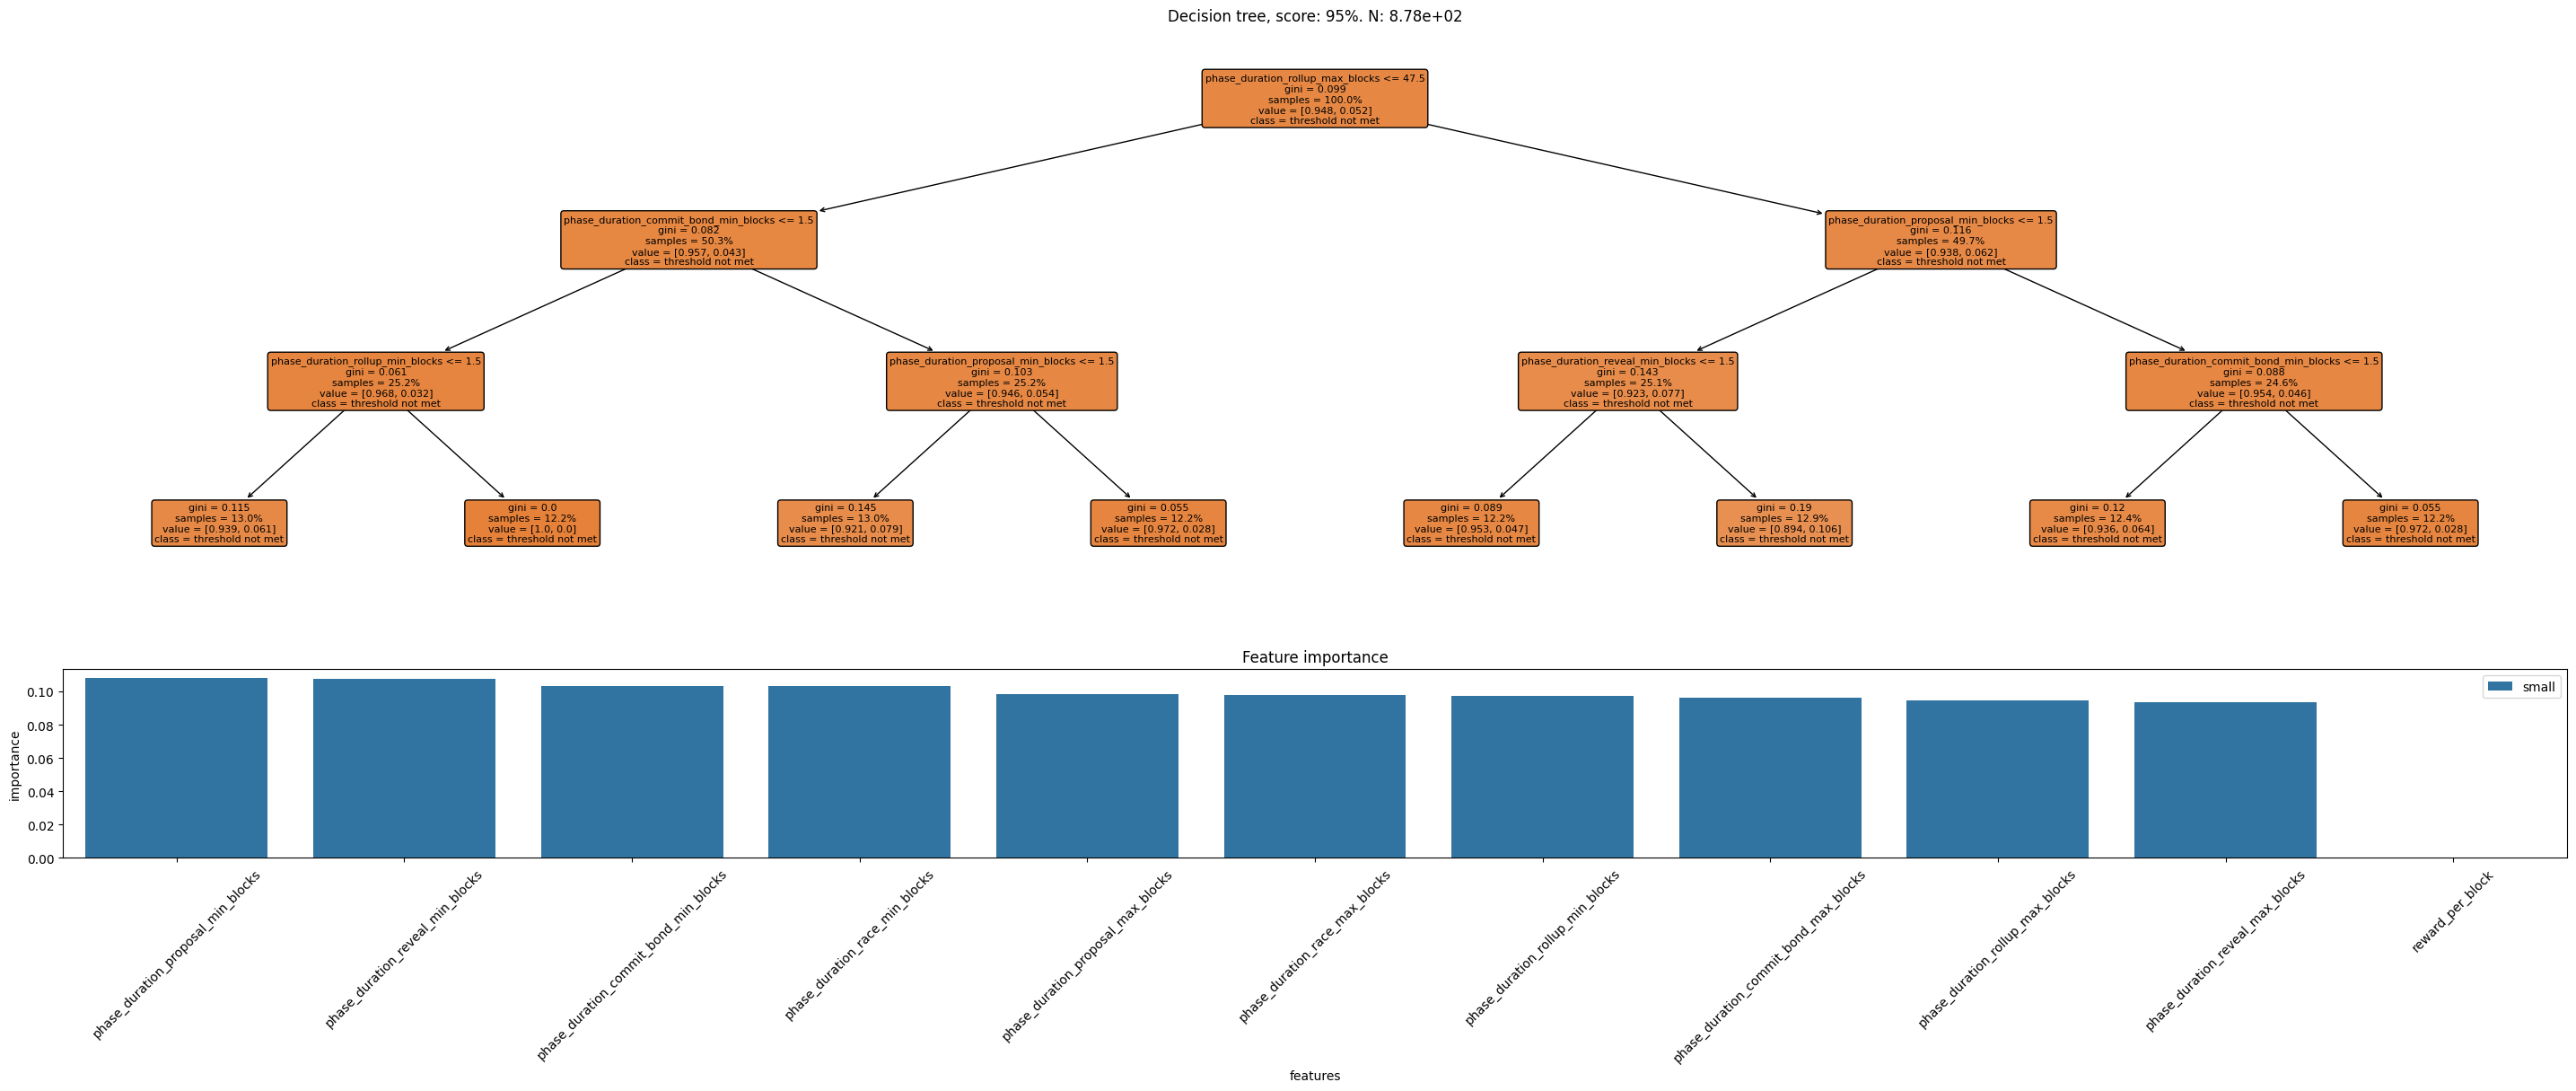

In [62]:
from sklearn.tree import plot_tree
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


df = all_kpi_df.reset_index()
kpi = 'fraction_race_mode'
features = list(set(governance_surface_params) - {kpi})
X = df.loc[:, features]
y = df.loc[:, kpi] > df.loc[:, kpi].median()

model = DecisionTreeClassifier(max_depth=3)
rf = RandomForestClassifier()
model.fit(X, y)
rf.fit(X, y)



rf_df = (pd.DataFrame(list(zip(X.columns, rf.feature_importances_)),
                    columns=['features', 'importance'])
        .sort_values(by='importance', ascending=False)
        )


fig, axes = plt.subplots(nrows=2,
                            figsize=(36, 12),
                            dpi=100,
                            gridspec_kw={'height_ratios': [3, 1]})

(ax_dt, ax_rf) = axes[0], axes[1]
plot_tree(model,
            rounded=True,
            proportion=True,
            fontsize=8,
            feature_names=X.columns,
            class_names=['threshold not met', 'threshold met'],
            filled=True,
            ax=ax_dt)
ax_dt.set_title(
    f'Decision tree, score: {model.score(X, y) :.0%}. N: {len(X) :.2e}')
sns.barplot(data=rf_df,
            x=rf_df.features,
            y=rf_df.importance,
            ax=ax_rf,
            label='small')
plt.setp(ax_rf.xaxis.get_majorticklabels(), rotation=45)
ax_rf.set_title(f'Feature importance')
plt.show()